In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

import optuna
import copy

# For reproducability
def set_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")


set_seed(50)

In [ ]:
""" from google.colab import files
uploaded = files.upload()

! pip install tensorboard
! pip install optuna
! pip install optuna-integration[tensorboard]
! pip install shap """

' from google.colab import files\nuploaded = files.upload()\n\n! pip install tensorboard\n! pip install optuna\n! pip install optuna-integration[tensorboard]\n! pip install shap '

#  Exploratory Data analysis

In [ ]:
# Converting the data into pandas dataframe
complete_data=pd.read_csv('Australian_Vehicle_Prices.csv')


print(f'Shape of data is {complete_data.shape}')

categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()

print(f'Categorical columns \n {categorical_cols}')
print(f'Numerical columns \n {numerical_cols}')

Shape of data is (16734, 19)
Categorical columns 
 ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'Kilometres', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats', 'Price']
Numerical columns 
 ['Year']


In [ ]:
# First few rows of the data
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [ ]:
# Missing cells
complete_data.isnull().sum().sort_values(ascending=False)

Seats                1705
Doors                1604
Location              450
BodyType              282
Car/Suv                28
Price                   3
Brand                   1
Model                   1
Year                    1
UsedOrNew               1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
CylindersinEngine       1
Kilometres              1
ColourExtInt            1
dtype: int64

# Visual CSV Data observations   
Some common observations-    
Some columns like kilometers, transmission, fuel are shown to having only few missing values but many values are fillled with symbols '-'.   
All vehicles with columns 'New available to order' have '-' in price instead of 0  
Some prices are filled with 'POA'



# Data cleaning & refinement

In [ ]:
# Fill NEW Available to order column with 0 kms
complete_data.loc[complete_data['Car/Suv'] == 'NEW Available to order', 'Kilometres'] = 0

# Converting into numeric columns
cols_to_convert = ['Kilometres','Price']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


# new list of categoric and numeric cols
categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()
print('Categorical cols-',categorical_cols)
print('Numerical cols-', numerical_cols)

# Missing cells
print('\nempty Cells-','\n',complete_data.isnull().sum().sort_values(ascending=False))

Categorical cols- ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats']
Numerical cols- ['Year', 'Kilometres', 'Price']

empty Cells- 
 Seats                1705
Doors                1604
Location              450
BodyType              282
Kilometres            156
Price                  53
Car/Suv                28
Model                   1
Year                    1
Brand                   1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
UsedOrNew               1
CylindersinEngine       1
ColourExtInt            1
dtype: int64


In [ ]:
complete_data.dropna(subset=['Price'], inplace=True)
complete_data.isnull().sum().sort_values(ascending=False)
complete_data_original_columns=complete_data.copy()

print('Mean price-', complete_data['Price'].mean())
print('Max price-', complete_data['Price'].max())
print('Min price-', complete_data['Price'].min())


Mean price- 37303.33463221629
Max price- 1500000.0
Min price- 88.0


In [ ]:
# Outliers check

from scipy import stats
complete_data = complete_data[complete_data['Price'] > 500]
z_scores = np.abs(stats.zscore(complete_data['Price']))
outliers = complete_data[z_scores > 10]
print(outliers)

               Brand    Year        Model                    Car/Suv  \
3036     Lamborghini  2019.0         Urus                        SUV   
3357         McLaren  2019.0         720S                Convertible   
3837   Mercedes-Benz  2023.0          G63             USED Dealer ad   
4046   Mercedes-Benz  2023.0          G63       Sydney Luxury Motors   
5271         Ferrari  2019.0         GTC4                      Coupe   
5502         Bentley  2020.0  Continental  Lorbek Luxury Cars Sydney   
10358    Lamborghini  2012.0    Aventador                      Coupe   
14924        Bentley  2023.0  Continental     NEW Available to order   
14932        Bentley  2023.0  Continental     NEW Available to order   
14943        Bentley  2023.0  Continental     NEW Available to order   
15053        McLaren  2023.0        600LT     NEW Available to order   
15079          Aston  2023.0       Martin     NEW Available to order   
15098        McLaren  2023.0         720S     NEW Available to o

In [ ]:
#  Converting some columns form large categorical sets to nummeric

complete_data['Engine_capacity']=complete_data['Engine'].str.split(',').str[1]
complete_data['Engine_capacity'] = complete_data['Engine_capacity'].str.replace(' L', '', regex=False)

complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()
complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()

complete_data[['City', 'State']] = complete_data['Location'].str.split(',', expand=True)

complete_data['CylindersinEngine'] =complete_data['CylindersinEngine'].str.split().str[0]
complete_data['Doors'] =complete_data['Doors'].str.split().str[0]
complete_data['Seats'] =complete_data['Seats'].str.split().str[0]

cols_to_convert = ['Engine_capacity','FuelConsumption','Doors','Seats']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
# unique values in each column
print('Unique values in each column','\n', complete_data.nunique())

Unique values in each column 
 Brand                   76
Year                    45
Model                  781
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Price                 3792
Engine_capacity         65
City                   606
State                    9
dtype: int64


In [ ]:
complete_data['Price'] = complete_data[['Price']].astype(int)
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,...,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price,Engine_capacity,City,State
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,...,White / Black,"Caringbah, NSW",4,SUV,4.0,7.0,51990,2.2,Caringbah,NSW
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,...,Black / Black,"Brookvale, NSW",4,Hatchback,5.0,5.0,19990,1.5,Brookvale,NSW
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,...,Grey / White,"Sylvania, NSW",4,Coupe,2.0,4.0,108988,2.0,Sylvania,NSW
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,...,White / Brown,"Mount Druitt, NSW",8,Coupe,2.0,4.0,32990,5.5,Mount Druitt,NSW
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,...,Grey / Black,"Castle Hill, NSW",4,SUV,4.0,5.0,34990,1.3,Castle Hill,NSW


In [ ]:
complete_data.isnull().sum().sort_values(ascending=False)

Engine_capacity      1766
Seats                1688
FuelConsumption      1681
Doors                1587
Location              449
City                  449
State                 449
BodyType              279
Kilometres            139
Car/Suv                26
Brand                   0
Title                   0
Model                   0
Year                    0
UsedOrNew               0
ColourExtInt            0
DriveType               0
FuelType                0
Transmission            0
Engine                  0
CylindersinEngine       0
Price                   0
dtype: int64

# Seperating training and test data

In [ ]:
# Extract last 1000 rows into a new DataFrame
Test_data = complete_data.tail(1000).copy()
y_actual_test=Test_data['Price'].astype(int)

# Remove last 1000 rows from the original DataFrame
Training_data= complete_data.iloc[:-1000]
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']

# Mutual information chart for feature importance

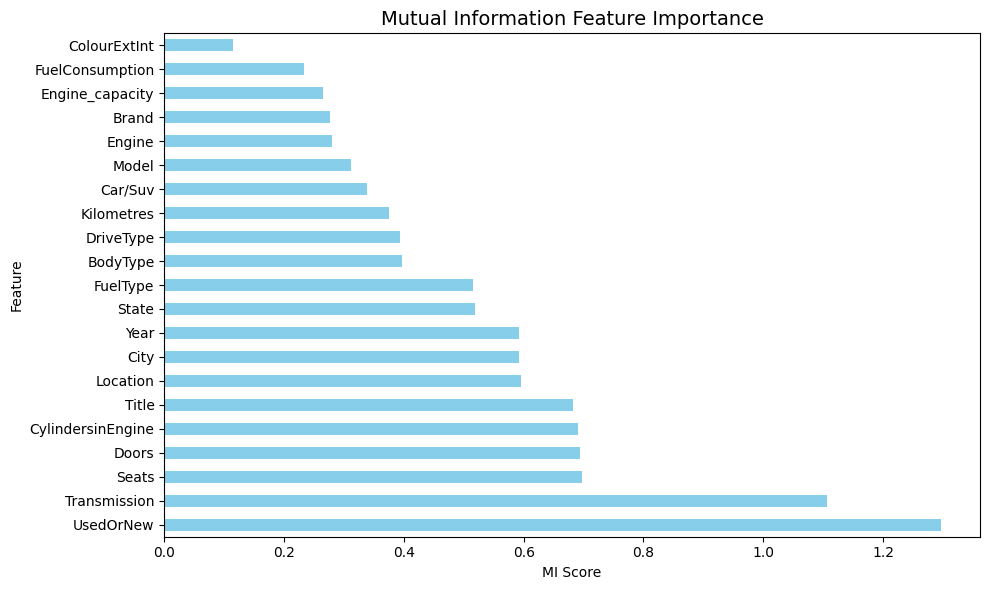

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Calculating mi scores
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X.fillna(0, inplace=True)

mi = mutual_info_classif(X, y,random_state=50)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Plotting mi scores
plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh', color='skyblue')
plt.title("Mutual Information Feature Importance", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Return to original x and y
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']


# Data splitting into training and validation data

In [ ]:
from sklearn.model_selection import KFold, train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=50)


# Mean encoding for 'Model' as it contains more than 700 different categories

target_col = 'Model'

X_train_te = X_train_full.copy()


kf = KFold(n_splits=5, shuffle=True, random_state=50)
target_means = pd.Series(index=X_train_te.index, dtype='float64')


for train_index,val_index in kf.split(X_train_te):
    X_tr, X_val = X_train_te.iloc[train_index], X_train_te.iloc[val_index]

    y_tr=y_train.iloc[train_index]

    means=y_tr.groupby(X_tr[target_col]).mean()
    target_means.iloc[val_index] = X_val[target_col].map(means)

target_means.fillna(y_train.mean(), inplace=True)

X_train_full_enc = X_train_full.copy()
X_train_full_enc[target_col+'_enc']=target_means
X_train_full_enc.drop(columns=[target_col], inplace=True)


means_full = y_train.groupby(X_train_full[target_col]).mean()

X_valid_full_enc = X_valid_full.copy()
X_valid_full_enc[target_col + '_enc'] = X_valid_full[target_col].map(means_full).fillna(y_train.mean())
X_valid_full_enc.drop(columns=[target_col], inplace=True)

Test_data_enc = Test_data.copy()
Test_data_enc[target_col + '_enc'] = Test_data[target_col].map(means_full).fillna(y_train.mean())
Test_data_enc.drop(columns=[target_col], inplace=True)



In [ ]:
# unique values in each column
print('Unique values in each column','\n', (pd.concat([X_train_full_enc, X_valid_full_enc, Test_data_enc], ignore_index=True)).nunique())

Unique values in each column 
 Brand                   76
Year                    45
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Engine_capacity         65
City                   606
State                    9
Model_enc             2213
Price                  579
dtype: int64


# Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

import joblib

categorical_cols = [cname for cname in X_train_full_enc.columns if
                    X_train_full_enc[cname].nunique() <= 76 and
                    (X_train_full_enc[cname].dtype == "object" or X_train_full_enc[cname].dtype.name == "category")]

numerical_cols = [cname for cname in X_train_full_enc.columns if
                  X_train_full_enc[cname].dtype in ['int64', 'float64']]


numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols),('cat', categorical_transformer, categorical_cols)])


X_train_pre = preprocessor.fit_transform(X_train_full_enc)
X_valid_pre = preprocessor.transform(X_valid_full_enc)
X_test_pre = preprocessor.transform(Test_data_enc)


# for reuse
Test_data_enc.to_csv("Test_data_enc.csv", index=False)
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

In [ ]:
num_features = numerical_cols

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)

feature_names = list(num_features) + list(cat_features)
print(feature_names)

['Year', 'FuelConsumption', 'Kilometres', 'Doors', 'Seats', 'Engine_capacity', 'Model_enc', 'Brand_Abarth', 'Brand_Alfa', 'Brand_Aston', 'Brand_Audi', 'Brand_BMW', 'Brand_BYD', 'Brand_Bentley', 'Brand_Caterham', 'Brand_Chery', 'Brand_Chevrolet', 'Brand_Chrysler', 'Brand_Citroen', 'Brand_Cupra', 'Brand_Daihatsu', 'Brand_Dodge', 'Brand_FPV', 'Brand_Ferrari', 'Brand_Fiat', 'Brand_Ford', 'Brand_Foton', 'Brand_GWM', 'Brand_Geely', 'Brand_Genesis', 'Brand_Great', 'Brand_HSV', 'Brand_Haval', 'Brand_Hino', 'Brand_Holden', 'Brand_Honda', 'Brand_Hummer', 'Brand_Hyundai', 'Brand_Ineos', 'Brand_Infiniti', 'Brand_International', 'Brand_Isuzu', 'Brand_Iveco', 'Brand_Jaguar', 'Brand_Jeep', 'Brand_Kia', 'Brand_LDV', 'Brand_Lamborghini', 'Brand_Land', 'Brand_Lexus', 'Brand_Lotus', 'Brand_MG', 'Brand_Mahindra', 'Brand_Maserati', 'Brand_Mazda', 'Brand_McLaren', 'Brand_Mercedes-Benz', 'Brand_Mini', 'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Opel', 'Brand_Peugeot', 'Brand_Polestar', 'Brand_Porsche', 'Brand

# Pytorch neural network

In [ ]:
total_epochs=400

X_train_tensor=torch.tensor(X_train_pre.todense(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
dataset=TensorDataset(X_train_tensor,y_train_tensor)

X_valid_tensor=torch.tensor(X_valid_pre.todense(), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
if y_valid_tensor.dim() == 1:
    y_valid_tensor = y_valid_tensor.unsqueeze(1)

X_test_tensor=torch.tensor(X_test_pre.todense(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_actual_test.values, dtype=torch.float32)
if y_test_tensor.dim() == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)


class Regressor(nn.Module):
    torch.manual_seed(50)
    def __init__(self, input_dim, units,num_layers):
        super().__init__()
        layers=[]
        in_dim=input_dim


        for i in range(num_layers):
            out_dim=units*2**(num_layers-(i+1))
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            in_dim=out_dim
        layers.append(nn.Linear(in_dim,1))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)

# Hyperparameter tuning

In [ ]:
def objective(trial):
    set_seed(50)

    # Early stopping
    patience=20
    min_delta=10
    best_valid_loss=float('inf')
    epochs_no_improve=0
    best_model_state = None

    num_layers=trial.suggest_int('num_layers',2,4)
    units = trial.suggest_int('units', 110, 200)
    batch_size = trial.suggest_int('batch_size', 500, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01)


    model = Regressor(input_dim=X_train_pre.shape[1], units=units,num_layers=num_layers)
    criterion=nn.L1Loss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)


    log_dir = f"runs_{timestamp}/fit/Trial_{trial.number}"
    writer=SummaryWriter(log_dir)


    loader=DataLoader(dataset, batch_size=batch_size, shuffle=True,  worker_init_fn=lambda worker_id: np.random.seed(50 + worker_id),generator=torch.Generator().manual_seed(50),num_workers=0)

    #Train the model
    for epoch in range(1,total_epochs+1):
        model.train()
        train_loss = 0
        total_samples = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred=model(X_batch)
            loss=criterion(y_pred,y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            total_samples += X_batch.size(0)
        train_loss = train_loss / total_samples

        model.eval()
        with torch.inference_mode():
            y_pred_valid = model(X_valid_tensor)
            valid_loss = torch.mean(torch.abs(y_pred_valid - y_valid_tensor))
            writer.add_scalars('Loss', {'Train': train_loss,'Valid': valid_loss}, epoch)

        print(f'{epoch}/{total_epochs} Train loss-{train_loss} Valid loss-{valid_loss}')

        if (best_valid_loss - valid_loss) > min_delta:
            # Improvement
            epochs_no_improve = 0
            best_valid_loss = valid_loss
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
        else:
            # No improvement
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {best_epoch} with val_loss {best_valid_loss:.4f}")
                break


    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best validation loss: {best_valid_loss:.4f} at epoch {best_epoch} \n")

    writer.add_scalar('Parameters/Units', units, trial.number)
    writer.add_scalar('Parameters/Batch_size', batch_size, trial.number)
    writer.add_scalar('Parameters/Learning_rate', learning_rate, trial.number)
    writer.add_scalar('Parameters/Num_layers', num_layers, trial.number)
    writer.add_scalar('Loss/Train_loss', train_loss, trial.number)
    writer.add_scalar('Loss/Valid_loss', valid_loss, trial.number)


    writer.close()

    return best_valid_loss


In [ ]:
set_seed(50)

study = optuna.create_study(direction="minimize",study_name="Hyperparametr optimization with pytorch",sampler=optuna.samplers.TPESampler(seed=50))
study.optimize(objective, n_trials=20)

[I 2025-08-05 11:46:10,445] A new study created in memory with name: Hyperparametr optimization with pytorch


1/400 Train loss-36944.45558571329 Valid loss-37805.97265625
2/400 Train loss-36936.29558983628 Valid loss-37792.640625
3/400 Train loss-36923.74485747668 Valid loss-37777.59375
4/400 Train loss-36906.08074484066 Valid loss-37758.62109375
5/400 Train loss-36882.69688913773 Valid loss-37730.84765625
6/400 Train loss-36853.19859594228 Valid loss-37699.8984375
7/400 Train loss-36817.66161268584 Valid loss-37659.79296875
8/400 Train loss-36774.87050208267 Valid loss-37611.89453125
9/400 Train loss-36724.87584079042 Valid loss-37552.34375
10/400 Train loss-36669.38485530931 Valid loss-37490.9296875
11/400 Train loss-36606.83079902493 Valid loss-37431.1875
12/400 Train loss-36538.06401404556 Valid loss-37362.15234375
13/400 Train loss-36462.32209466428 Valid loss-37287.15625
14/400 Train loss-36374.546980254505 Valid loss-37180.33203125
15/400 Train loss-36271.70639972298 Valid loss-37096.52734375
16/400 Train loss-36148.714696767376 Valid loss-36944.59375
17/400 Train loss-36031.98786770568

[I 2025-08-05 11:49:53,732] Trial 0 finished with value: 5622.76220703125 and parameters: {'num_layers': 3, 'units': 130, 'batch_size': 627, 'learning_rate': 0.004566969187504993}. Best is trial 0 with value: 5622.76220703125.


196/400 Train loss-5716.200941319368 Valid loss-5664.8310546875
Early stopping at epoch 176 with val_loss 5622.7622
Best validation loss: 5622.7622 at epoch 176 

1/400 Train loss-36939.85677415498 Valid loss-37793.7265625
2/400 Train loss-36917.076610331635 Valid loss-37759.671875
3/400 Train loss-36880.1435546875 Valid loss-37712.96484375
4/400 Train loss-36825.58834901148 Valid loss-37649.2421875
5/400 Train loss-36751.37416294643 Valid loss-37562.5625
6/400 Train loss-36656.38879145408 Valid loss-37454.42578125
7/400 Train loss-36538.96835140306 Valid loss-37318.87109375
8/400 Train loss-36393.42713647959 Valid loss-37153.6953125
9/400 Train loss-36209.47552614796 Valid loss-36980.546875
10/400 Train loss-36000.8251554528 Valid loss-36739.09765625
11/400 Train loss-35768.483577806124 Valid loss-36499.53515625
12/400 Train loss-35513.55309311225 Valid loss-36241.50390625
13/400 Train loss-35234.11488560268 Valid loss-35944.46875
14/400 Train loss-34930.086694834186 Valid loss-35628.

[I 2025-08-05 11:53:18,806] Trial 1 finished with value: 5216.41552734375 and parameters: {'num_layers': 3, 'units': 200, 'batch_size': 704, 'learning_rate': 0.007947045953557424}. Best is trial 1 with value: 5216.41552734375.


144/400 Train loss-4489.734186912069 Valid loss-5234.884765625
Early stopping at epoch 124 with val_loss 5216.4155
Best validation loss: 5216.4155 at epoch 124 

1/400 Train loss-36945.32725836306 Valid loss-37806.98828125
2/400 Train loss-36938.99611243423 Valid loss-37795.56640625
3/400 Train loss-36929.427305260484 Valid loss-37784.8671875
4/400 Train loss-36916.15959728007 Valid loss-37772.04296875
5/400 Train loss-36898.91712702537 Valid loss-37752.69921875
6/400 Train loss-36877.41746178452 Valid loss-37727.1171875
7/400 Train loss-36851.50321586765 Valid loss-37697.37109375
8/400 Train loss-36820.79672926299 Valid loss-37664.828125
9/400 Train loss-36785.31846026985 Valid loss-37625.5859375
10/400 Train loss-36745.16742192482 Valid loss-37581.69921875
11/400 Train loss-36700.739098062324 Valid loss-37534.5859375
12/400 Train loss-36651.29974583217 Valid loss-37484.65234375
13/400 Train loss-36597.94196023746 Valid loss-37428.00390625
14/400 Train loss-36539.00078754036 Valid los

[I 2025-08-05 12:01:48,032] Trial 2 finished with value: 5288.294921875 and parameters: {'num_layers': 4, 'units': 138, 'batch_size': 673, 'learning_rate': 0.004165883357469062}. Best is trial 1 with value: 5216.41552734375.


255/400 Train loss-4590.980761158223 Valid loss-5364.78125
Early stopping at epoch 235 with val_loss 5288.2949
Best validation loss: 5288.2949 at epoch 235 

1/400 Train loss-36944.13300183354 Valid loss-37807.4609375
2/400 Train loss-36934.39425939443 Valid loss-37793.72265625
3/400 Train loss-36919.7493865344 Valid loss-37770.32421875
4/400 Train loss-36899.464764964825 Valid loss-37744.078125
5/400 Train loss-36872.84132665517 Valid loss-37712.61328125
6/400 Train loss-36839.32367441605 Valid loss-37673.97265625
7/400 Train loss-36798.69166782924 Valid loss-37627.80859375
8/400 Train loss-36750.46060024962 Valid loss-37574.98046875
9/400 Train loss-36693.39184585883 Valid loss-37508.53515625
10/400 Train loss-36628.67360391422 Valid loss-37437.921875
11/400 Train loss-36554.73961779536 Valid loss-37358.17578125
12/400 Train loss-36473.10891630212 Valid loss-37270.15625
13/400 Train loss-36381.83384299765 Valid loss-37172.94140625
14/400 Train loss-36279.45450638752 Valid loss-37067.

[I 2025-08-05 12:48:20,129] Trial 3 finished with value: 5364.5458984375 and parameters: {'num_layers': 2, 'units': 198, 'batch_size': 955, 'learning_rate': 0.006039613933499126}. Best is trial 1 with value: 5216.41552734375.


231/400 Train loss-4518.183952409394 Valid loss-5374.4580078125
Early stopping at epoch 211 with val_loss 5364.5459
Best validation loss: 5364.5459 at epoch 211 

1/400 Train loss-36944.08259317826 Valid loss-37808.19921875
2/400 Train loss-36936.63751936932 Valid loss-37797.796875
3/400 Train loss-36926.08875570492 Valid loss-37781.1484375
4/400 Train loss-36911.9358053402 Valid loss-37763.8671875
5/400 Train loss-36893.9434319321 Valid loss-37742.6875
6/400 Train loss-36871.66641858159 Valid loss-37718.40234375
7/400 Train loss-36845.122461124345 Valid loss-37687.62890625
8/400 Train loss-36813.81355565908 Valid loss-37652.28125
9/400 Train loss-36777.74682336924 Valid loss-37614.0703125
10/400 Train loss-36736.50856049207 Valid loss-37569.671875
11/400 Train loss-36690.09642558195 Valid loss-37519.00390625
12/400 Train loss-36639.353248440486 Valid loss-37464.62109375
13/400 Train loss-36581.8981871313 Valid loss-37399.08984375
14/400 Train loss-36518.460966149156 Valid loss-37335.4

[I 2025-08-05 12:50:51,052] Trial 4 finished with value: 5238.306640625 and parameters: {'num_layers': 2, 'units': 190, 'batch_size': 837, 'learning_rate': 0.004519787028747055}. Best is trial 1 with value: 5216.41552734375.


264/400 Train loss-4515.493756196936 Valid loss-5263.2255859375
Early stopping at epoch 244 with val_loss 5238.3066
Best validation loss: 5238.3066 at epoch 244 

1/400 Train loss-36944.7021484375 Valid loss-37806.6640625
2/400 Train loss-36936.89653918208 Valid loss-37794.06640625
3/400 Train loss-36925.156363351 Valid loss-37777.24609375
4/400 Train loss-36909.06478196748 Valid loss-37757.9921875
5/400 Train loss-36887.792803705954 Valid loss-37733.50390625
6/400 Train loss-36860.957435452205 Valid loss-37702.76953125
7/400 Train loss-36828.33435432278 Valid loss-37665.046875
8/400 Train loss-36789.436679762235 Valid loss-37623.65625
9/400 Train loss-36743.329121492345 Valid loss-37574.921875
10/400 Train loss-36690.07365199498 Valid loss-37518.24609375
11/400 Train loss-36629.313200035875 Valid loss-37448.59375
12/400 Train loss-36560.97021733498 Valid loss-37381.86328125
13/400 Train loss-36484.01956612723 Valid loss-37306.65234375
14/400 Train loss-36393.94862832828 Valid loss-372

[I 2025-08-05 12:54:20,390] Trial 5 finished with value: 5287.630859375 and parameters: {'num_layers': 3, 'units': 157, 'batch_size': 964, 'learning_rate': 0.00614235762135034}. Best is trial 1 with value: 5216.41552734375.


239/400 Train loss-5062.877251294194 Valid loss-5473.08056640625
Early stopping at epoch 219 with val_loss 5287.6309
Best validation loss: 5287.6309 at epoch 219 

1/400 Train loss-36946.59101260438 Valid loss-37810.5859375
2/400 Train loss-36944.90546962193 Valid loss-37807.55859375
3/400 Train loss-36942.944906429366 Valid loss-37804.703125
4/400 Train loss-36940.64135181661 Valid loss-37802.62890625
5/400 Train loss-36937.85838317871 Valid loss-37799.9140625
6/400 Train loss-36934.604973306465 Valid loss-37796.65234375
7/400 Train loss-36930.91140061982 Valid loss-37792.88671875
8/400 Train loss-36926.75968715123 Valid loss-37788.4375
9/400 Train loss-36922.132608530475 Valid loss-37783.19921875
10/400 Train loss-36917.05878806601 Valid loss-37777.8671875
11/400 Train loss-36911.5632747728 Valid loss-37772.265625
12/400 Train loss-36905.56017194475 Valid loss-37765.046875
13/400 Train loss-36899.062290736605 Valid loss-37759.57421875
14/400 Train loss-36892.10271095743 Valid loss-37

[I 2025-08-05 14:08:47,767] Trial 6 finished with value: 10244.140625 and parameters: {'num_layers': 4, 'units': 114, 'batch_size': 663, 'learning_rate': 0.001507614752543441}. Best is trial 1 with value: 5216.41552734375.


400/400 Train loss-9814.699425638939 Valid loss-10385.017578125
Best validation loss: 10244.1406 at epoch 398 

1/400 Train loss-36943.3296502561 Valid loss-37806.43359375
2/400 Train loss-36931.58204495177 Valid loss-37789.5703125
3/400 Train loss-36914.01713219468 Valid loss-37761.8359375
4/400 Train loss-36889.63529470016 Valid loss-37730.6171875
5/400 Train loss-36857.38170359086 Valid loss-37692.02734375
6/400 Train loss-36816.67867325764 Valid loss-37644.26171875
7/400 Train loss-36766.55054863132 Valid loss-37588.4765625
8/400 Train loss-36707.101020968694 Valid loss-37520.2265625
9/400 Train loss-36637.51434326172 Valid loss-37441.76171875
10/400 Train loss-36555.06266722387 Valid loss-37355.2734375
11/400 Train loss-36459.49968236806 Valid loss-37249.5390625
12/400 Train loss-36344.80918853137 Valid loss-37151.67578125
13/400 Train loss-36219.1404798858 Valid loss-37016.59765625
14/400 Train loss-36084.9808642329 Valid loss-36878.08984375
15/400 Train loss-35939.265917719626 V

[I 2025-08-05 14:10:42,405] Trial 7 finished with value: 5279.8173828125 and parameters: {'num_layers': 2, 'units': 194, 'batch_size': 969, 'learning_rate': 0.007426834366906844}. Best is trial 1 with value: 5216.41552734375.


218/400 Train loss-4577.4898068175025 Valid loss-5297.1181640625
Early stopping at epoch 198 with val_loss 5279.8174
Best validation loss: 5279.8174 at epoch 198 

1/400 Train loss-36945.43650163923 Valid loss-37807.83984375
2/400 Train loss-36940.326154436385 Valid loss-37799.12890625
3/400 Train loss-36933.46004813058 Valid loss-37791.65625
4/400 Train loss-36924.51695033482 Valid loss-37782.1953125
5/400 Train loss-36913.22953578404 Valid loss-37770.19921875
6/400 Train loss-36899.41192626953 Valid loss-37755.21875
7/400 Train loss-36882.95685250418 Valid loss-37736.81640625
8/400 Train loss-36863.53567940848 Valid loss-37715.61328125
9/400 Train loss-36841.44416155134 Valid loss-37688.97265625
10/400 Train loss-36816.25978742327 Valid loss-37662.7265625
11/400 Train loss-36788.548958914624 Valid loss-37632.5625
12/400 Train loss-36757.21725027902 Valid loss-37601.69921875
13/400 Train loss-36722.814509800504 Valid loss-37563.03125
14/400 Train loss-36686.15482875279 Valid loss-3752

[I 2025-08-05 14:19:22,155] Trial 8 finished with value: 5188.41748046875 and parameters: {'num_layers': 4, 'units': 152, 'batch_size': 966, 'learning_rate': 0.004657782190067268}. Best is trial 8 with value: 5188.41748046875.


276/400 Train loss-4283.723221370152 Valid loss-5280.46728515625
Early stopping at epoch 256 with val_loss 5188.4175
Best validation loss: 5188.4175 at epoch 256 

1/400 Train loss-36945.61759668467 Valid loss-37808.8203125
2/400 Train loss-36941.21940457091 Valid loss-37800.8984375
3/400 Train loss-36935.44994650082 Valid loss-37793.83984375
4/400 Train loss-36928.10008488869 Valid loss-37786.41015625
5/400 Train loss-36919.11021921586 Valid loss-37777.60546875
6/400 Train loss-36908.36517614248 Valid loss-37766.15234375
7/400 Train loss-36895.82589410276 Valid loss-37752.12109375
8/400 Train loss-36881.43762269312 Valid loss-37735.73046875
9/400 Train loss-36865.02863265057 Valid loss-37717.9296875
10/400 Train loss-36846.7392176414 Valid loss-37697.58984375
11/400 Train loss-36826.29575270049 Valid loss-37676.65625
12/400 Train loss-36803.625514439176 Valid loss-37652.0546875
13/400 Train loss-36778.38849126076 Valid loss-37624.87109375
14/400 Train loss-36751.3036224988 Valid loss-

[I 2025-08-05 14:31:23,086] Trial 9 finished with value: 5287.48828125 and parameters: {'num_layers': 4, 'units': 169, 'batch_size': 799, 'learning_rate': 0.0029983545287170827}. Best is trial 8 with value: 5188.41748046875.


308/400 Train loss-4449.518670899527 Valid loss-5354.89599609375
Early stopping at epoch 288 with val_loss 5287.4883
Best validation loss: 5287.4883 at epoch 288 

1/400 Train loss-36937.7028908243 Valid loss-37778.5234375
2/400 Train loss-36900.18424022441 Valid loss-37728.61328125
3/400 Train loss-36830.11015662368 Valid loss-37636.2265625
4/400 Train loss-36719.981519115216 Valid loss-37495.53515625
5/400 Train loss-36564.57823461416 Valid loss-37310.953125
6/400 Train loss-36351.34605781399 Valid loss-37055.49609375
7/400 Train loss-36074.56503358179 Valid loss-36900.69921875
8/400 Train loss-35690.21738324846 Valid loss-36332.48828125
9/400 Train loss-35253.64638612708 Valid loss-35857.56640625
10/400 Train loss-34772.455470960966 Valid loss-35367.96875
11/400 Train loss-34236.3959837933 Valid loss-34812.0703125
12/400 Train loss-33647.2669648151 Valid loss-34177.34375
13/400 Train loss-33009.93320402807 Valid loss-33510.64453125
14/400 Train loss-32327.252537007236 Valid loss-328

[I 2025-08-05 14:36:44,635] Trial 10 finished with value: 5198.1650390625 and parameters: {'num_layers': 4, 'units': 170, 'batch_size': 541, 'learning_rate': 0.009277899808653355}. Best is trial 8 with value: 5188.41748046875.


131/400 Train loss-4619.468412263052 Valid loss-5299.9111328125
Early stopping at epoch 111 with val_loss 5198.1650
Best validation loss: 5198.1650 at epoch 111 

1/400 Train loss-36937.168361118864 Valid loss-37779.8515625
2/400 Train loss-36900.04624098174 Valid loss-37727.234375
3/400 Train loss-36831.70856709383 Valid loss-37640.65234375
4/400 Train loss-36724.97621248206 Valid loss-37511.375
5/400 Train loss-36573.33520632374 Valid loss-37323.2890625
6/400 Train loss-36374.504786900114 Valid loss-37113.0546875
7/400 Train loss-36100.4833012795 Valid loss-36917.48828125
8/400 Train loss-35722.59825414541 Valid loss-36333.75390625
9/400 Train loss-35300.78918581593 Valid loss-35900.44921875
10/400 Train loss-34833.80410704321 Valid loss-35420.66015625
11/400 Train loss-34307.76369990135 Valid loss-34869.94140625
12/400 Train loss-33732.66098209303 Valid loss-34279.1796875
13/400 Train loss-33106.794314637475 Valid loss-33620.38671875
14/400 Train loss-32438.665029720385 Valid loss-3

[I 2025-08-05 14:42:52,748] Trial 11 finished with value: 5572.97509765625 and parameters: {'num_layers': 4, 'units': 172, 'batch_size': 548, 'learning_rate': 0.009505370920187793}. Best is trial 8 with value: 5188.41748046875.


142/400 Train loss-5004.863607756945 Valid loss-5666.396484375
Early stopping at epoch 122 with val_loss 5572.9751
Best validation loss: 5572.9751 at epoch 122 

1/400 Train loss-36937.02431441326 Valid loss-37777.15625
2/400 Train loss-36898.938297193876 Valid loss-37729.296875
3/400 Train loss-36827.91119260204 Valid loss-37635.61328125
4/400 Train loss-36715.65513392857 Valid loss-37497.09375
5/400 Train loss-36557.13655931123 Valid loss-37297.3203125
6/400 Train loss-36344.09980867347 Valid loss-37307.25390625
7/400 Train loss-36019.88512436225 Valid loss-36688.51171875
8/400 Train loss-35646.063695790814 Valid loss-36268.44140625
9/400 Train loss-35223.45846619898 Valid loss-35805.8515625
10/400 Train loss-34750.11184630102 Valid loss-35293.75390625
11/400 Train loss-34220.7109375 Valid loss-34747.78515625
12/400 Train loss-33640.071827168365 Valid loss-34132.84765625
13/400 Train loss-33003.81871811225 Valid loss-33492.62890625
14/400 Train loss-32328.07134885204 Valid loss-32720

[I 2025-08-05 14:47:29,918] Trial 12 finished with value: 5236.6376953125 and parameters: {'num_layers': 4, 'units': 151, 'batch_size': 512, 'learning_rate': 0.009421688334959795}. Best is trial 8 with value: 5188.41748046875.


126/400 Train loss-4921.419254225128 Valid loss-5319.5107421875
Early stopping at epoch 106 with val_loss 5236.6377
Best validation loss: 5236.6377 at epoch 106 

1/400 Train loss-36943.27070212851 Valid loss-37797.8671875
2/400 Train loss-36929.88545818718 Valid loss-37777.6796875
3/400 Train loss-36909.6483976403 Valid loss-37756.28125
4/400 Train loss-36880.84493084343 Valid loss-37724.41796875
5/400 Train loss-36842.34312220982 Valid loss-37679.5703125
6/400 Train loss-36793.041583625636 Valid loss-37620.46875
7/400 Train loss-36732.89729651626 Valid loss-37555.37890625
8/400 Train loss-36660.8765495456 Valid loss-37469.328125
9/400 Train loss-36576.41436144771 Valid loss-37368.1171875
10/400 Train loss-36475.35654496174 Valid loss-37270.140625
11/400 Train loss-36358.23599430006 Valid loss-37264.82421875
12/400 Train loss-36199.42885044643 Valid loss-37097.39453125
13/400 Train loss-36020.641910475126 Valid loss-36844.53125
14/400 Train loss-35837.9539321588 Valid loss-36573.85156

[I 2025-08-05 14:53:21,974] Trial 13 finished with value: 5258.81640625 and parameters: {'num_layers': 4, 'units': 175, 'batch_size': 880, 'learning_rate': 0.007496098054450189}. Best is trial 8 with value: 5188.41748046875.


148/400 Train loss-4425.077582845883 Valid loss-5321.865234375
Early stopping at epoch 128 with val_loss 5258.8164
Best validation loss: 5258.8164 at epoch 128 

1/400 Train loss-36945.165115356445 Valid loss-37808.09765625
2/400 Train loss-36939.31561715262 Valid loss-37797.671875
3/400 Train loss-36930.80244227818 Valid loss-37787.02734375
4/400 Train loss-36919.371337890625 Valid loss-37775.03125
5/400 Train loss-36904.83526175363 Valid loss-37759.30859375
6/400 Train loss-36887.082127162386 Valid loss-37740.11328125
7/400 Train loss-36865.91504342215 Valid loss-37716.953125
8/400 Train loss-36841.37831333705 Valid loss-37689.625
9/400 Train loss-36813.09214128767 Valid loss-37658.48828125
10/400 Train loss-36781.283303397046 Valid loss-37624.9609375
11/400 Train loss-36745.29874529158 Valid loss-37586.4140625
12/400 Train loss-36706.14189365932 Valid loss-37543.8203125
13/400 Train loss-36662.96705409459 Valid loss-37500.46875
14/400 Train loss-36614.68655831473 Valid loss-37449.60

[I 2025-08-05 14:58:55,888] Trial 14 finished with value: 5351.6142578125 and parameters: {'num_layers': 3, 'units': 153, 'batch_size': 574, 'learning_rate': 0.002987662162588409}. Best is trial 8 with value: 5188.41748046875.


279/400 Train loss-4601.249587467739 Valid loss-5395.88720703125
Early stopping at epoch 259 with val_loss 5351.6143
Best validation loss: 5351.6143 at epoch 259 

1/400 Train loss-36942.79045821209 Valid loss-37796.92578125
2/400 Train loss-36927.817200018435 Valid loss-37776.71875
3/400 Train loss-36903.34831767179 Valid loss-37749.68359375
4/400 Train loss-36867.28669832191 Valid loss-37704.09765625
5/400 Train loss-36817.41242171307 Valid loss-37642.671875
6/400 Train loss-36753.31992324517 Valid loss-37569.60546875
7/400 Train loss-36674.284071941765 Valid loss-37481.7578125
8/400 Train loss-36579.25424256617 Valid loss-37376.84375
9/400 Train loss-36468.50251116072 Valid loss-37248.76953125
10/400 Train loss-36335.616859903144 Valid loss-37089.13671875
11/400 Train loss-36157.433427148935 Valid loss-37026.05859375
12/400 Train loss-35934.037548765846 Valid loss-36669.39453125
13/400 Train loss-35713.96694790587 Valid loss-36448.4609375
14/400 Train loss-35479.865679215414 Valid l

[I 2025-08-05 15:03:54,989] Trial 15 finished with value: 5195.822265625 and parameters: {'num_layers': 4, 'units': 137, 'batch_size': 755, 'learning_rate': 0.008485961554923895}. Best is trial 8 with value: 5188.41748046875.


164/400 Train loss-4471.734289519641 Valid loss-5291.2626953125
Early stopping at epoch 144 with val_loss 5195.8223
Best validation loss: 5195.8223 at epoch 144 

1/400 Train loss-36943.863350693064 Valid loss-37804.75
2/400 Train loss-36933.6062597158 Valid loss-37787.171875
3/400 Train loss-36917.58686392648 Valid loss-37766.12890625
4/400 Train loss-36894.48133382992 Valid loss-37740.20703125
5/400 Train loss-36863.47752598354 Valid loss-37706.25390625
6/400 Train loss-36824.01168698681 Valid loss-37661.73046875
7/400 Train loss-36775.380204492685 Valid loss-37605.3515625
8/400 Train loss-36716.41053803113 Valid loss-37538.6640625
9/400 Train loss-36646.943026484274 Valid loss-37462.765625
10/400 Train loss-36568.24591033313 Valid loss-37379.35546875
11/400 Train loss-36477.955948498784 Valid loss-37278.76953125
12/400 Train loss-36377.0106375558 Valid loss-37179.15234375
13/400 Train loss-36256.78997709313 Valid loss-37047.6875
14/400 Train loss-36118.265437223476 Valid loss-36874.

[I 2025-08-05 15:06:50,820] Trial 16 finished with value: 5322.78759765625 and parameters: {'num_layers': 3, 'units': 134, 'batch_size': 755, 'learning_rate': 0.006615845297919804}. Best is trial 8 with value: 5188.41748046875.


198/400 Train loss-4734.745660392606 Valid loss-5346.75732421875
Early stopping at epoch 178 with val_loss 5322.7876
Best validation loss: 5322.7876 at epoch 178 

1/400 Train loss-36945.29950916524 Valid loss-37807.5234375
2/400 Train loss-36939.68074440469 Valid loss-37796.88671875
3/400 Train loss-36931.58911288514 Valid loss-37788.72265625
4/400 Train loss-36920.66223237952 Valid loss-37776.93359375
5/400 Train loss-36906.4913881263 Valid loss-37760.47265625
6/400 Train loss-36888.71547683404 Valid loss-37739.9140625
7/400 Train loss-36867.27364956603 Valid loss-37715.01953125
8/400 Train loss-36842.03307326959 Valid loss-37686.921875
9/400 Train loss-36812.66779280682 Valid loss-37658.4140625
10/400 Train loss-36779.502768068895 Valid loss-37618.890625
11/400 Train loss-36739.354578757775 Valid loss-37577.01953125
12/400 Train loss-36689.59681327976 Valid loss-37524.76171875
13/400 Train loss-36636.43710794254 Valid loss-37473.0546875
14/400 Train loss-36580.456424012475 Valid los

[I 2025-08-05 15:13:32,141] Trial 17 finished with value: 5287.51318359375 and parameters: {'num_layers': 4, 'units': 120, 'batch_size': 895, 'learning_rate': 0.005272311741924377}. Best is trial 8 with value: 5188.41748046875.


256/400 Train loss-5041.387469972883 Valid loss-5328.556640625
Early stopping at epoch 236 with val_loss 5287.5132
Best validation loss: 5287.5132 at epoch 236 

1/400 Train loss-36942.46860239457 Valid loss-37795.00390625
2/400 Train loss-36926.71925354004 Valid loss-37774.88671875
3/400 Train loss-36900.938811010245 Valid loss-37744.27734375
4/400 Train loss-36862.46231265944 Valid loss-37698.671875
5/400 Train loss-36809.97763186085 Valid loss-37635.375
6/400 Train loss-36742.29820376026 Valid loss-37557.34765625
7/400 Train loss-36658.629019601 Valid loss-37464.171875
8/400 Train loss-36557.67797384457 Valid loss-37348.453125
9/400 Train loss-36439.63178331025 Valid loss-37219.17578125
10/400 Train loss-36288.980845860075 Valid loss-37090.99609375
11/400 Train loss-36082.4668937216 Valid loss-36904.3828125
12/400 Train loss-35870.69918449558 Valid loss-36600.671875
13/400 Train loss-35646.38537644367 Valid loss-36363.41015625
14/400 Train loss-35403.869984529454 Valid loss-36111.41

[I 2025-08-05 15:18:39,828] Trial 18 finished with value: 5212.16552734375 and parameters: {'num_layers': 4, 'units': 143, 'batch_size': 759, 'learning_rate': 0.008469089122190767}. Best is trial 8 with value: 5188.41748046875.


157/400 Train loss-4447.730728908461 Valid loss-5264.701171875
Early stopping at epoch 137 with val_loss 5212.1655
Best validation loss: 5212.1655 at epoch 137 

1/400 Train loss-36946.02621023996 Valid loss-37810.046875
2/400 Train loss-36943.08172731983 Valid loss-37805.5390625
3/400 Train loss-36939.34993572624 Valid loss-37799.65234375
4/400 Train loss-36934.63504837971 Valid loss-37794.35546875
5/400 Train loss-36928.837430992906 Valid loss-37788.5625
6/400 Train loss-36921.9259830397 Valid loss-37781.7109375
7/400 Train loss-36913.761509486605 Valid loss-37773.02734375
8/400 Train loss-36904.451092155614 Valid loss-37762.80078125
9/400 Train loss-36893.844177246094 Valid loss-37751.02734375
10/400 Train loss-36881.9168788365 Valid loss-37737.9765625
11/400 Train loss-36868.823891153144 Valid loss-37724.3046875
12/400 Train loss-36854.30193219866 Valid loss-37709.16015625
13/400 Train loss-36838.41369504345 Valid loss-37692.65234375
14/400 Train loss-36821.36836958904 Valid loss-3

[I 2025-08-05 15:23:57,242] Trial 19 finished with value: 5287.5068359375 and parameters: {'num_layers': 3, 'units': 125, 'batch_size': 884, 'learning_rate': 0.0029796544398634417}. Best is trial 8 with value: 5188.41748046875.


390/400 Train loss-4656.759741802605 Valid loss-5286.18603515625
Early stopping at epoch 370 with val_loss 5287.5068
Best validation loss: 5287.5068 at epoch 370 



In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

Best hyperparameters: {'num_layers': 4, 'units': 152, 'batch_size': 966, 'learning_rate': 0.004657782190067268}
Best validation loss: 5188.41748046875


# Building the model with tuned hyperparameters

In [ ]:
set_seed(50)


best_params = study.best_params

model = Regressor(input_dim=X_train_pre.shape[1],
                    units=best_params['units'],
                    num_layers=best_params['num_layers'])

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True,    worker_init_fn=lambda worker_id: np.random.seed(50 + worker_id),generator=torch.Generator().manual_seed(50))

patience = 20
min_delta = 10
best_valid_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(1,total_epochs+1):
    model.train()
    total_loss = 0
    total_samples = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        total_samples += X_batch.size(0)

    train_loss = total_loss / total_samples

    model.eval()
    with torch.inference_mode():
        y_pred_valid = model(X_valid_tensor)
        valid_loss = torch.mean(torch.abs(y_pred_valid - y_valid_tensor))

    print(f'{epoch}/{total_epochs} Train loss-{train_loss} Valid loss-{valid_loss}')

    if (best_valid_loss-valid_loss)>min_delta:
        best_valid_loss=valid_loss
        epochs_no_improve=0
        best_model_state_current = copy.deepcopy(model.state_dict())
        best_model_state = best_model_state_current
        best_epoch=epoch
    else:
        epochs_no_improve+=1
        best_model_state = copy.deepcopy(model.state_dict())
        best_epoch=epoch
        if epochs_no_improve>=patience:
            best_epoch=epoch-epochs_no_improve
            best_model_state = best_model_state_current
            print(f"Early stopping at epoch {best_epoch}")
            break


if best_model_state is not None:
    model.load_state_dict(best_model_state)
print(f"Best validation loss: {best_valid_loss:.4f} at epoch {best_epoch} \n")

1/400 Train loss-36945.43650163923 Valid loss-37807.83984375
2/400 Train loss-36940.326154436385 Valid loss-37799.12890625
3/400 Train loss-36933.46004813058 Valid loss-37791.65625
4/400 Train loss-36924.51695033482 Valid loss-37782.1953125
5/400 Train loss-36913.22953578404 Valid loss-37770.19921875
6/400 Train loss-36899.41192626953 Valid loss-37755.21875
7/400 Train loss-36882.95685250418 Valid loss-37736.81640625
8/400 Train loss-36863.53567940848 Valid loss-37715.61328125
9/400 Train loss-36841.44416155134 Valid loss-37688.97265625
10/400 Train loss-36816.25978742327 Valid loss-37662.7265625
11/400 Train loss-36788.548958914624 Valid loss-37632.5625
12/400 Train loss-36757.21725027902 Valid loss-37601.69921875
13/400 Train loss-36722.814509800504 Valid loss-37563.03125
14/400 Train loss-36686.15482875279 Valid loss-37524.3125
15/400 Train loss-36645.60216413225 Valid loss-37482.59375
16/400 Train loss-36602.47559029715 Valid loss-37437.03125
17/400 Train loss-36555.80288260324 Val

# Save the pytorch model

In [ ]:
# Save everything
saved_model = {
    'model_state_dict': best_model_state,
    'model_params': {
        'input_dim': X_train_tensor.shape[1],
        'units': best_params['units'],
        'num_layers': best_params['num_layers']
    },
}

torch.save(saved_model, 'best_model_complete_pt.pth')

# Predicting on test data

In [ ]:
import shap

set_seed(50)

model.eval()
with torch.no_grad():
    y_pred_test =model(X_test_tensor)

y_pred_test = y_pred_test.flatten()
Prediction=pd.Series(y_pred_test.tolist())
Prediction.name = 'Predicted Price'
Prediction=pd.DataFrame(Prediction)
Prediction['Predicted Price'] = Prediction['Predicted Price'].astype(int)
print(Prediction)

     Predicted Price
0              30801
1              28058
2              11728
3              19187
4              30526
..               ...
995            40383
996            50491
997            34977
998            35620
999            57329

[1000 rows x 1 columns]


# Recording and saving outputs

In [ ]:
from sklearn.metrics import mean_absolute_error

y_actual_test.name = 'Actual Price'
y_actual_test=pd.DataFrame(y_actual_test)

Final_output = complete_data_original_columns.tail(1000).copy()
Final_output['Predicted Price']=Prediction['Predicted Price'].values
mae = mean_absolute_error(y_actual_test, y_pred_test)
print(f"Test MAE: {mae:.4f}")
Final_output.to_csv('Final_results.csv', index=True)

Test MAE: 6427.8458


PermutationExplainer explainer: 1001it [05:12,  3.15it/s]                          
C:\Users\Abhay.Sharma\AppData\Local\Temp\ipykernel_10456\681507425.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_np,feature_names=feature_names,max_display=40, show=False)


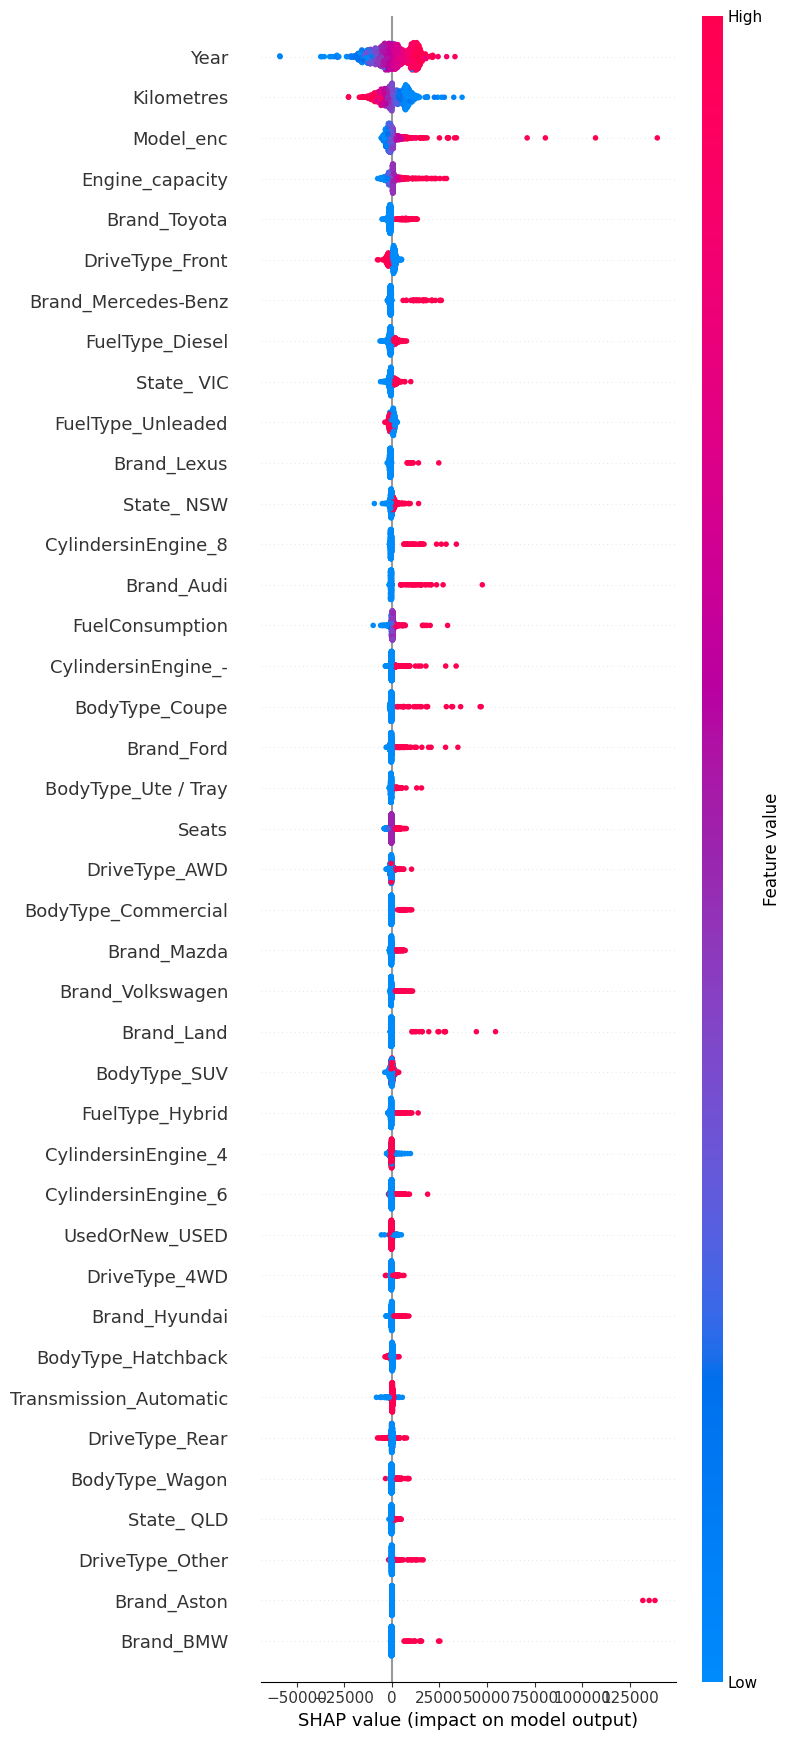

In [ ]:
from io import BytesIO
import numpy as np
from PIL import Image

def plot_pred_vs_actual(y_actual_test, y_pred_test):
    plt.figure(figsize=(6,4))
    plt.scatter(y_actual_test, y_pred_test, alpha=0.6)
    plt.plot([y_actual_test.min(), y_actual_test.max()], [y_actual_test.min(), y_actual_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.grid(True)
    return plt.gcf()


def plot_residuals(y_actual_test, y_pred_test):
    residuals = y_pred_test - y_actual_test
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.hlines(0, min(y_pred_test), max(y_pred_test), colors='red', linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    return plt.gcf()

# Convert tensors to NumPy
X_train_np = X_train_tensor.detach().cpu().numpy()
X_test_np = X_test_tensor.detach().cpu().numpy()

explainer = shap.Explainer(lambda x: model(torch.tensor(x, dtype=torch.float32)), X_train_np)
shap_values = explainer(X_test_np)
shap.summary_plot(shap_values.values, X_test_np,feature_names=feature_names,max_display=40, show=False)
fig_shap = plt.gcf()
# Convert plot to image tensor
buf = BytesIO()
fig_shap.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
img = Image.open(buf).convert("RGB")
img = np.array(img).transpose(2, 0, 1)  # Convert to (C, H, W)

writer = SummaryWriter(f"runs_{timestamp}/Predictions")

fig1 = plot_pred_vs_actual(y_actual_test['Actual Price'].values, y_pred_test.tolist())
writer.add_figure("Predicted vs Actual", fig1, global_step=0)

fig2 = plot_residuals(y_actual_test['Actual Price'].values, y_pred_test.tolist())
writer.add_figure("Residual Plot", fig2, global_step=0)

writer.add_image("SHAP Summary", img, global_step=0 )

writer.close()

In [ ]:
shap.initjs()
# Convert tensors to NumPy
X_train_np = X_train_tensor.detach().cpu().numpy()
X_test_np = X_test_tensor.detach().cpu().numpy()



explainer = shap.Explainer(lambda x: model(torch.tensor(x, dtype=torch.float32)), X_train_np)
single_instance = X_test_np[[308]]  # shape: (1, n_features)
explanation = explainer(single_instance)
# Convert float32s to float64 or Python float
base_value=explanation.base_values[0].item()
shap_values = explanation.values[0].astype(float)
feature_values = single_instance[0].astype(float)

# Plot the force plot
shap.plots.force(base_value, shap_values, feature_values,feature_names=feature_names,)

# Model parameters summary

In [ ]:
print(model)
from torchinfo import summary
summary(model)

Regressor(
  (net): Sequential(
    (0): Linear(in_features=128, out_features=1216, bias=True)
    (1): BatchNorm1d(1216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1216, out_features=608, bias=True)
    (5): BatchNorm1d(608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=608, out_features=304, bias=True)
    (9): BatchNorm1d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=304, out_features=152, bias=True)
    (13): BatchNorm1d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=152, out_features=1, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
Regressor                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       156,864
│    └─BatchNorm1d: 2-2                  2,432
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       739,936
│    └─BatchNorm1d: 2-6                  1,216
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       185,136
│    └─BatchNorm1d: 2-10                 608
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      46,360
│    └─BatchNorm1d: 2-14                 304
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      153
Total params: 1,133,009
Trainable params: 1,133,009
Non-trainable params: 0